In [42]:
# i wonder if theres gonna b any diff in exgtrapolation if i feed in the input as 2 feature vectors instead of 1... then attn will do work
#however attn shud saturate out at 0 and 1 for softmax in extreme inputs... meaning the vector we output as c1 v1+ c2 v2 shud approach a constant... 
# lets see if this is true

In [43]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

x = torch.linspace(-5,5,20)
x_matrix, y_matrix = torch.meshgrid(x,x)
print(y_matrix.shape)

x_flat, y_flat = x_matrix.flatten(), y_matrix.flatten()

#i want (400,2,1), not 1,2 like yesterday
input_data = (torch.vstack((x_flat,y_flat)).T).unsqueeze(2)
print(input_data.shape)

output_data = (input_data[:,0,:]**2+input_data[:,1,:]**2).unsqueeze(2)
print(output_data.shape)

dataset = torch.utils.data.TensorDataset(input_data,output_data)
loader = torch.utils.data.DataLoader(dataset, batch_size=4)


torch.Size([20, 20])
torch.Size([400, 2, 1])
torch.Size([400, 1, 1])


In [44]:
class Transformer(nn.Module):
    def __init__(self,in_d,hidden_d,out_d,n_heads):
        super().__init__()
        self.embed = nn.Linear(in_d,hidden_d)
        self.attn = nn.MultiheadAttention(hidden_d,n_heads, batch_first=True) 
        self.ffn = nn.Sequential(nn.Linear(hidden_d, 4*hidden_d), nn.ReLU(),  nn.Linear(4*hidden_d, hidden_d) )
        self.unembed = nn.Linear(hidden_d,out_d)
        self.norm = nn.LayerNorm(hidden_d)

    def forward(self,x):
        x = self.embed(x)
        x = x + self.attn(x,x,x)[0]
     #   x = self.norm(x)
        x = x+ self.ffn(x)
     #   x= self.norm(x)
        x = x.mean(keepdim=True, dim=1)
        x = self.unembed(x)
        return x

In [45]:
my_transformer = Transformer(1,16,1,4)
my_optim = torch.optim.Adam(my_transformer.parameters(),lr=4e-4)
loss_fn = nn.MSELoss()

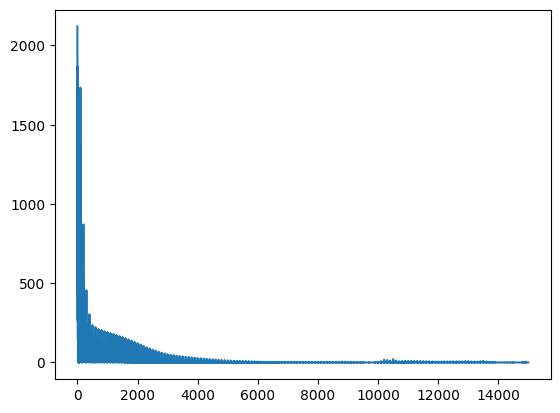

In [46]:
loss_list=[]
for epoch in range(150):
    for in_batch,out_batch in loader:
        preds = my_transformer(in_batch)
        loss = loss_fn(preds, out_batch)
        loss_list.append(loss.detach())
        loss.backward()
        my_optim.step()
        my_optim.zero_grad()

plt.plot(loss_list)

torch.Size([20, 20])
torch.Size([3600, 2, 1])


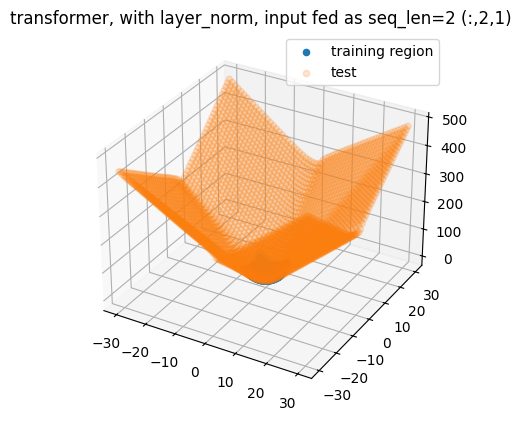

In [51]:
my_transformer.eval()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(input_data[:,0,0],input_data[:,1,0],output_data[:,0,0],label="training region")

####
whatevs=30
xx = torch.linspace(-whatevs,whatevs,60)
xx_matrix, yy_matrix = torch.meshgrid(xx,xx)
print(y_matrix.shape)

xx_flat, yy_flat = xx_matrix.flatten(), yy_matrix.flatten()

#i want (400,2,1), not 1,2 like yesterday
iinput_data = (torch.vstack((xx_flat,yy_flat)).T).unsqueeze(2)
print(iinput_data.shape)


ax.scatter(iinput_data[:,0,0],iinput_data[:,1,0],my_transformer(iinput_data).detach().squeeze(),alpha=.2,label="test")
ax.set_title("transformer, with layer_norm, input fed as seq_len=2 (:,2,1)")
ax.legend()